In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter



In [2]:
user_engagement=pd.read_csv('takehome_user_engagement.csv')
user_engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [3]:
take_home_users=pd.read_csv('takehome_users.csv')
take_home_users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [4]:
# First, lets count unique users and find the range of dates we are working with.
print len(user_engagement.user_id.unique())
print sorted(take_home_users.creation_time)[0],sorted(take_home_users.creation_time)[-1]

8823
2012-05-31 00:43:27 2014-05-30 23:59:19


In [5]:
#Next, lets get email domains and some idea about creation source in the take_home file
def get_email_domain(email):
    return email.split('@')[1]

take_home_users['domain']=take_home_users.email.apply(get_email_domain)
print len(take_home_users.domain.unique()),len(take_home_users.creation_source.unique())

domains=Counter(take_home_users.domain)
print domains.most_common(15)


1184 5
[('gmail.com', 3562), ('yahoo.com', 2447), ('jourrapide.com', 1259), ('cuvox.de', 1202), ('gustr.com', 1179), ('hotmail.com', 1165), ('oqpze.com', 2), ('xvnbr.com', 2), ('rerwl.com', 2), ('xybhi.com', 2), ('mumdc.com', 2), ('qgjbc.com', 2), ('dqwln.com', 2), ('luque.com', 2), ('ymohu.com', 1)]


We see that there are only a few domains that have a significant number of entries.  So, lets set domeains to reflect that reality.

In [6]:
main_domains=[x[0] for x in domains.most_common(6)]

def get_main_domains(x):
    if x in main_domains:
        return x
    return 'other'

take_home_users['domain']=take_home_users.domain.apply(get_main_domains)


In [7]:
# Now let's one hot encode domains and creation_source
take_home_users=pd.get_dummies(take_home_users,columns=['domain','creation_source'],prefix='D_')
take_home_users.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,D__cuvox.de,...,D__gustr.com,D__hotmail.com,D__jourrapide.com,D__other,D__yahoo.com,D__GUEST_INVITE,D__ORG_INVITE,D__PERSONAL_PROJECTS,D__SIGNUP,D__SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0,...,0,0,0,0,1,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,0,...,1,0,0,0,0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0,...,1,0,0,0,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0,...,0,0,0,0,1,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0,...,0,0,0,0,1,1,0,0,0,0


There is about two full years of data and almost 9K total users.  Next, lets turn the derive a date column from the timestamp and use this to find the users with three logins in a seven day period.


In [8]:
def make_date(str1):
    tmp=str1
    tmp=tmp.split(' ')
    tmp2=tmp[0].split('-')
    year=int(tmp2[0])
    month=int(tmp2[1])
    day=int(tmp2[2])
    return datetime.date(year,month,day)


user_engagement['login_dates']=user_engagement.time_stamp.apply(make_date)
print 'Range of dates',min(user_engagement.login_dates),min(user_engagement.login_dates)

all_dates=sorted(list(set(user_engagement.login_dates)))
adopted_users=[]
for d in all_dates:
    tmp=user_engagement.loc[(user_engagement.login_dates>=d) &(user_engagement.login_dates < d+datetime.timedelta(days=7)),:]
    tmp2=tmp.pivot_table(index=['user_id'],values='visited',aggfunc='sum').sort_values('visited',ascending=False)
    tmp3=tmp2.loc[tmp2.visited>=3,:]
    tmp3.reset_index(drop=False,inplace=True)
    for i in tmp3.user_id:
        adopted_users.append(i)
        
adopted_users=sorted(list(set(adopted_users)))
print 'Number of adopted users {}'.format(len(adopted_users))

Range of dates 2012-05-31 2012-05-31
Number of adopted users 1602


Now that we have a list of adopted users, create a dataframe usable for making a mode.  First add a column for adopted users to user_engagement dataframe and then merge with take_home dataframe

In [9]:
frequent_users=pd.DataFrame(columns=['user_id','adopted_user'])
frequent_users['user_id']=adopted_users
frequent_users['adopted_user']=1

take_home_users.rename(columns={'object_id':'user_id'},inplace=True)

train_df=take_home_users.merge(frequent_users,how='outer',on='user_id')
train_df.adopted_user.fillna(0,inplace=True)
train_df.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,D__cuvox.de,...,D__hotmail.com,D__jourrapide.com,D__other,D__yahoo.com,D__GUEST_INVITE,D__ORG_INVITE,D__PERSONAL_PROJECTS,D__SIGNUP,D__SIGNUP_GOOGLE_AUTH,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0,...,0,0,0,1,1,0,0,0,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,0,...,0,0,0,0,0,1,0,0,0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0,...,0,0,0,0,0,1,0,0,0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0,...,0,0,0,1,1,0,0,0,0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0,...,0,0,0,1,1,0,0,0,0,0.0


In [10]:
#  Missing Values check shows two columns with missing values: invited by user and last seesion creation time
# Invited by user can safely be set to zero.  creation time is not so clear.  That needs a more careful look.
train_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 22 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
D__cuvox.de                   12000 non-null uint8
D__gmail.com                  12000 non-null uint8
D__gustr.com                  12000 non-null uint8
D__hotmail.com                12000 non-null uint8
D__jourrapide.com             12000 non-null uint8
D__other                      12000 non-null uint8
D__yahoo.com                  12000 non-null uint8
D__GUEST_INVITE               12000 non-null uint8
D__ORG_INVITE      

In [11]:
# A careful look shows that none of the missing login information are in teh adopted users (which 
#we could have assumed but it is safer to check).  So, in terms of impact on becoming an adopted user,
#those rows can be dropped.
train_df.loc[(train_df.last_session_creation_time.isnull()==1)&(train_df.adopted_user==1),'user_id'].count()

0

In [12]:
train_df.invited_by_user_id.fillna(0,inplace=True)
train_df.dropna(axis=0,inplace=True)
train_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 22 columns):
user_id                       8823 non-null int64
creation_time                 8823 non-null object
name                          8823 non-null object
email                         8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null float64
D__cuvox.de                   8823 non-null uint8
D__gmail.com                  8823 non-null uint8
D__gustr.com                  8823 non-null uint8
D__hotmail.com                8823 non-null uint8
D__jourrapide.com             8823 non-null uint8
D__other                      8823 non-null uint8
D__yahoo.com                  8823 non-null uint8
D__GUEST_INVITE               8823 non-null uint8
D__ORG_INVITE                 8823 

Now we have a clean dataframe.  The objective is to find the features that help to predict which users adopt the software.  First, lets do something simple.

In [14]:
corr=train_df.corr()
len(corr['adopted_user'][:-1])

18

1338452406.0 1402066730.0
63614324.0
636143.24


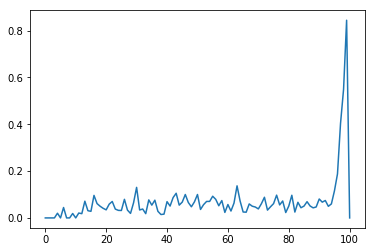

 
-1 729


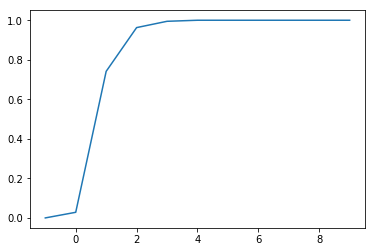

In [15]:
#Add some features that look at time from creation date and the difference

train_df['creation_date']=train_df.creation_time.apply(make_date)
train_df['last_login_date']=train_df.last_session_creation_time.apply(datetime.date.fromtimestamp)
train_df['login_delta_days']=train_df.apply(lambda x: (x.last_login_date-x.creation_date).days,axis=1)

print min(train_df.last_session_creation_time),max(train_df.last_session_creation_time)
print max(train_df.last_session_creation_time)-min(train_df.last_session_creation_time)
print (max(train_df.last_session_creation_time)-min(train_df.last_session_creation_time))/100

train_df['last_log']=train_df.last_session_creation_time.apply(lambda x: int((x-1338452406)/636143))
tmp=train_df.pivot_table(index='last_log',values='adopted_user',aggfunc='mean')
plt.plot(tmp)
plt.show()

print ' '
print min(train_df.login_delta_days),max(train_df.login_delta_days)
train_df['login_delta_days2']=train_df.apply(lambda x: int(x.login_delta_days/73),axis=1)
tmp=train_df.pivot_table(index='login_delta_days2',values='adopted_user',aggfunc='mean')
plt.plot(tmp)
plt.show()



D__yahoo.com                 -0.038832
D__SIGNUP                    -0.036937
D__ORG_INVITE                -0.015820
D__SIGNUP_GOOGLE_AUTH        -0.015741
D__cuvox.de                  -0.012442
D__gustr.com                 -0.009890
enabled_for_marketing_drip    0.002058
D__jourrapide.com             0.002619
opted_in_to_mailing_list      0.006650
D__gmail.com                  0.006865
D__other                      0.009918
invited_by_user_id            0.019898
D__PERSONAL_PROJECTS          0.026429
D__hotmail.com                0.052336
D__GUEST_INVITE               0.054847
org_id                        0.074744
last_log                      0.396078
login_delta_days              0.787346
adopted_user                  1.000000
Name: adopted_user, dtype: float64


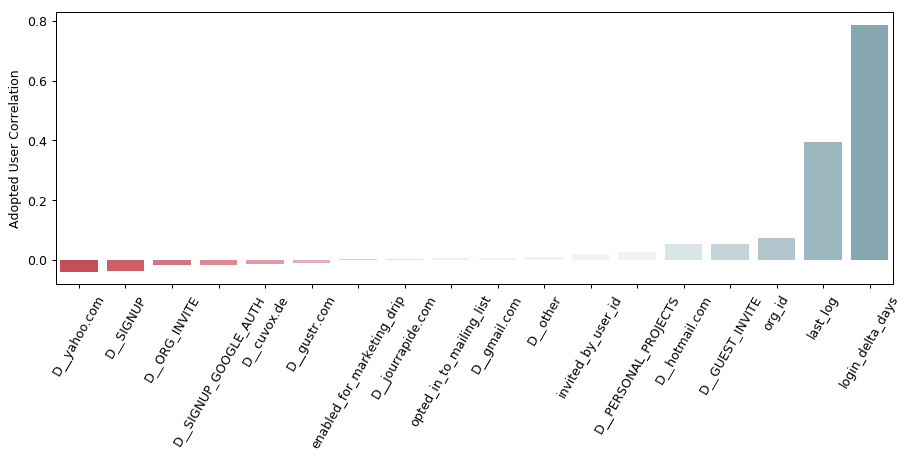

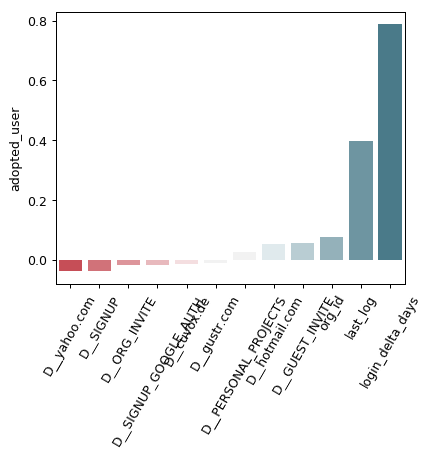

In [89]:
plt.figure(figsize=(12,4),dpi=90)
tmp=train_df.copy()
tmp.drop(['user_id','last_session_creation_time','creation_date','creation_time','name','email',
             'creation_time','last_login_date','login_delta_days2'],axis=1,inplace=True)
corr=tmp.corr().sort_values('adopted_user')
print corr['adopted_user']
pal=sns.diverging_palette(10, 220, sep=50, n=21)
sns.barplot(corr['adopted_user'].index[:-1],corr['adopted_user'][:-1],palette=pal)
plt.xticks(rotation=60)
plt.ylabel("Adopted User Correlation")
plt.show()

key_cols=['D__yahoo.com','D__SIGNUP','D__ORG_INVITE','D__SIGNUP_GOOGLE_AUTH','D__cuvox.de','D__gustr.com',
         'D__PERSONAL_PROJECTS','D__hotmail.com','D__GUEST_INVITE','org_id','last_log','login_delta_days']

tmp2=tmp[key_cols]
pal2=sns.diverging_palette(10, 220, sep=50, n=12)
plt.figure(figsize=(5,4),dpi=90)
sns.barplot(tmp2.columns,corr['adopted_user'][key_cols],palette=pal2)
plt.xticks(rotation=60)
plt.show()

Based on this quick look, time features that relate last login and account establishment date should be the most important. 

Let's check this with a lightly optimized model.

In [62]:
#prep train_df for model:

y_train=train_df.adopted_user
X_train=train_df.copy()
X_train.drop(['user_id','last_session_creation_time','creation_date','creation_time','name','email','adopted_user',
             'creation_time','last_login_date','login_delta_days2'],axis=1,inplace=True)
tmp_for_feats=X_train

In [63]:
for c in X_train.columns:
    print c, type(X_train.loc[0,c])
    if isinstance(X_train[c].any(),str):
        print 'Found string'

opted_in_to_mailing_list <type 'numpy.int64'>
enabled_for_marketing_drip <type 'numpy.int64'>
org_id <type 'numpy.int64'>
invited_by_user_id <type 'numpy.float64'>
D__cuvox.de <type 'numpy.uint8'>
D__gmail.com <type 'numpy.uint8'>
D__gustr.com <type 'numpy.uint8'>
D__hotmail.com <type 'numpy.uint8'>
D__jourrapide.com <type 'numpy.uint8'>
D__other <type 'numpy.uint8'>
D__yahoo.com <type 'numpy.uint8'>
D__GUEST_INVITE <type 'numpy.uint8'>
D__ORG_INVITE <type 'numpy.uint8'>
D__PERSONAL_PROJECTS <type 'numpy.uint8'>
D__SIGNUP <type 'numpy.uint8'>
D__SIGNUP_GOOGLE_AUTH <type 'numpy.uint8'>
login_delta_days <type 'numpy.int64'>
last_log <type 'numpy.int64'>


In [70]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,roc_auc_score
import sklearn.cross_validation as cv
import sklearn.feature_selection as feature_selection

def randomly_optimize_classifier(clf,name,train_df,target,param_search,\
                n_iter=10,scoring='roc_auc',cv_num=5,verbose=3,\
                random_state=0,test_size=0.33,n_jobs=2):#5
    
    tmp_df=train_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(\
        train_df, target, test_size=test_size,random_state=random_state)

    clf=RandomizedSearchCV(clf,param_search,scoring=scoring,\
        cv=cv_num,n_iter=n_iter,verbose=verbose,n_jobs=n_jobs)
    
    clf.fit(X_train,y_train)

    rocky=roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    print '{} has a roc_aucscore_of {:6.5f}'.format(name,rocky)
    
    print name+'Best Params',clf.best_params_
    print name+'Best Score',clf.best_score_
    print name+'_score',clf.score(X_test, y_test)
    print '\n'
    
    

    return clf,X_train,X_test,y_train,y_test
        
    
n_iter=10   
rf_name='Random Forrest Classifier'

rf_param_search={'n_estimators':[10,50,100,200,400],
                 'criterion':['gini'],
                 'max_features':['sqrt','log2'],
                 'max_depth':[2,4,6],
                 'min_samples_split':[2,4,6],
                 'min_samples_leaf':[1,2,3]}


rf=RandomForestClassifier()
rf_opt,X_train,X_test,y_train,y_test=randomly_optimize_classifier(rf,rf_name,X_train,\
        y_train,rf_param_search,n_iter=n_iter,n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   16.5s finished


Random Forrest Classifier has a roc_aucscore_of 0.98334
Random Forrest ClassifierBest Params {'min_samples_leaf': 1, 'n_estimators': 200, 'max_features': 'sqrt', 'criterion': 'gini', 'min_samples_split': 4, 'max_depth': 6}
Random Forrest ClassifierBest Score 0.987282408468
Random Forrest Classifier_score 0.983344025662




In [71]:
from sklearn.neural_network import MLPClassifier
n_iter=10   

mlp_name='MPC'

mlp=MLPClassifier()
print 'mlp classifier established'


hls=[(10,10)]
                          
    
mlp_param_search={'hidden_layer_sizes':hls,
                    'max_iter':[3,5,10,20,30,50],
                    'alpha':[1e-4,1e-5],
                    'solver':['lbfgs', 'sgd', 'adam'],
                    'tol':[1e-4,1e-5],
                    'learning_rate_init':[0.001,0.01,0.05,0.1,0.2,0.3]}


mlp=MLPClassifier()
mlp_opt,X_train,X_test,y_train,y_test=randomly_optimize_classifier(rf,rf_name,X_train,\
        y_train,rf_param_search,n_iter=n_iter,n_jobs=5)





mlp classifier established
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    9.1s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   14.6s finished


Random Forrest Classifier has a roc_aucscore_of 0.98993
Random Forrest ClassifierBest Params {'min_samples_leaf': 3, 'n_estimators': 200, 'max_features': 'log2', 'criterion': 'gini', 'min_samples_split': 2, 'max_depth': 6}
Random Forrest ClassifierBest Score 0.985419727589
Random Forrest Classifier_score 0.989926678887




In [72]:
# Note: Randomized Optimizer does not return feature importances.  It is necessary to fit a true
# RF classifers to get them.  Using the best parameters from above:

rf=RandomForestClassifier(min_samples_leaf=1, n_estimators=50, max_features='sqrt',\
                criterion='gini', min_samples_split=6, max_depth=4)

rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [68]:
y_pred=rf.predict(X_test)
con_mat=confusion_matrix(y_true=y_test,y_pred=y_pred)
print con_mat.view()

[[1578   18]
 [  35  320]]


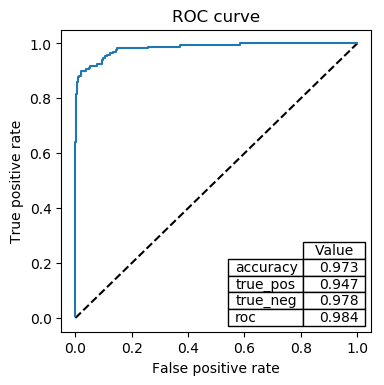

In [80]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr_rf, tpr_rf)

from pandas.plotting import table

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(4)
fig.set_figheight(4)
fig.set_dpi(100)

perf_table=pd.DataFrame(index=['accuracy','true_pos','true_neg','roc'],columns=['Value'])
perf_table.loc['accuracy','Value']='{:4.3f}'.format(float((con_mat[0,0]+con_mat[1,1]))/con_mat.sum())
perf_table.loc['true_pos','Value']='{:4.3f}'.format(float(con_mat[1,1])/(con_mat[0,1]+con_mat[1,1]))
perf_table.loc['true_neg','Value']='{:4.3f}'.format(float(con_mat[0,0])/(con_mat[0,0]+con_mat[1,0]))
perf_table.loc['roc','Value']='{:4.3f}'.format(roc_auc)

table(ax, perf_table,loc='lower right', colWidths=[0.2, 0.2, 0.2])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')

                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.show()



In [162]:
feature_df=pd.DataFrame()
feature_df['feats']=tmp_for_feats.columns
feature_df['importances']=rf.feature_importances_
feature_df.sort_values('importances',ascending=False,inplace=True)
feature_df.head(5)

,feats,importances
16,login_delta_days,0.675311
17,last_log,0.268881
2,org_id,0.022348
3,invited_by_user_id,0.010147
11,D__GUEST_INVITE,0.003809


In [175]:
def cut_string(str1):
    return str1[:5]

a='asdfesdfgdsfer'
cut_string(a)

'asdfe'

In [191]:
def cut_string(str1):
    return str1[:5]

tab1=feature_df.copy()
tab1.sort_values('importances',ascending=False,inplace=True)
tab1.reset_index(drop=True,inplace=True)
tab1=tab1.loc[tab1.index<5,:]
tab1.rename(columns={'feats':'vars','importances':'val'}, inplace=True)
tab1.vars=['legacy','l_login','1st_login','inviter','recruited']
tab1['val']=tab1['val'].astype(str)
tab1['val']=tab1.val.apply(cut_string)

#tab1.rank=imps
print type(tab1.val[0])
tab1.head()

<type 'str'>


,vars,val
0,legacy,0.675
1,l_login,0.268
2,1st_login,0.022
3,inviter,0.010
4,recruited,0.003


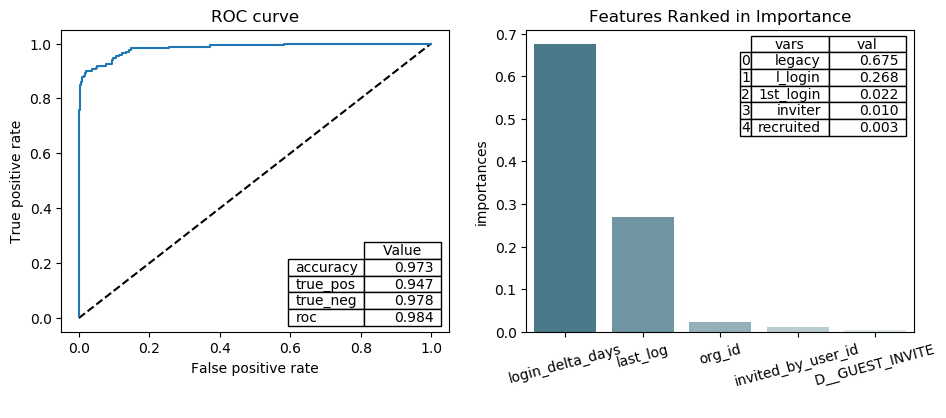

In [214]:
plt.subplots(nrows=1,ncols=2,figsize=(11,4),dpi=100)


#fig, ax = plt.subplots(1, 2)
#fig.set_figwidth(10)
#fig.set_figheight(4)
#fig.set_dpi(100)


#perf_table=pd.DataFrame(index=['accuracy','true_pos','true_neg','roc'],columns=['Value'])
#perf_table.loc['accuracy','Value']='{:4.3f}'.format(float((con_mat[0,0]+con_mat[1,1]))/con_mat.sum())
#perf_table.loc['true_pos','Value']='{:4.3f}'.format(float(con_mat[1,1])/(con_mat[0,1]+con_mat[1,1]))
#perf_table.loc['true_neg','Value']='{:4.3f}'.format(float(con_mat[0,0])/(con_mat[0,0]+con_mat[1,0]))
#perf_table.loc['roc','Value']='{:4.3f}'.format(roc_auc)

ax=plt.subplot(1,2,1)
table(ax,data=perf_table,loc='lower right', colWidths=[0.2, 0.2, 0.2])


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')

                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

key_cols=['D__yahoo.com','D__SIGNUP','D__ORG_INVITE','D__SIGNUP_GOOGLE_AUTH','D__cuvox.de','D__gustr.com',
         'D__PERSONAL_PROJECTS','D__hotmail.com','D__GUEST_INVITE','org_id','last_log','login_delta_days']


tmp2=tmp[key_cols]
pal2=sns.diverging_palette(220, 10, sep=50, n=12)
ax=plt.subplot(1,2,2)
#tab1=feature_df.loc[feature_df.index<5,:]

table(ax,data=tab1,loc='upper right', colWidths=[0.2, 0.2, 0.2])
#plt.figure(figsize=(5,4),dpi=90)
#sns.barplot(tmp2.columns,corr['adopted_user'][key_cols],palette=pal2)
sns.barplot(feature_df.feats[:5],feature_df.importances[:5],palette=pal2)


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    rotation=15) # labels along the bottom edge are off
plt.xticks=(['legacy','l_log','1st_log','inviter','recruit'])

plt.xlabel(' ')
plt.title('Features Ranked in Importance')

plt.savefig('Important_Feature.png')
plt.show()